In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model

In [3]:
# path='/content/model.h5'
# dataset=path.File(path,"r")
# import h5py

im_shape = (432,288)
TRAINING_DIR = 'test/dataset/training_set_abhi_equal'
TEST_DIR = 'test/dataset/test_set_abhi_equal'
seed = 10
BATCH_SIZE = 8

In [4]:
data_generator = ImageDataGenerator(
        validation_split=0.2,
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False,
        fill_mode='nearest')
val_data_generator = ImageDataGenerator( preprocessing_function=preprocess_input,validation_split=0.2)

In [5]:
train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,class_mode='categorical', batch_size=BATCH_SIZE, subset="training")
validation_generator = val_data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")
test_generator = ImageDataGenerator( preprocessing_function=preprocess_input,validation_split=0.0)
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 1930 images belonging to 2 classes.
Found 482 images belonging to 2 classes.
Found 659 images belonging to 2 classes.
Classes: ['abnormal', 'normal']


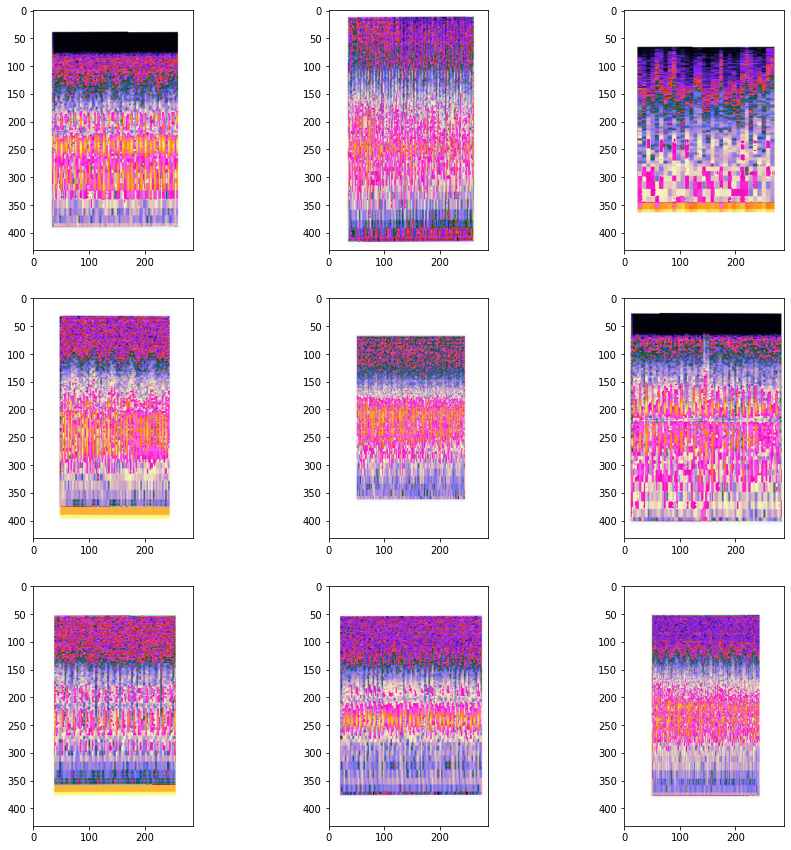

In [6]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = train_generator.next()[0]*255
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

In [7]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

In [8]:
def repeat_elem(tensor, rep):
     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


In [9]:
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  
    shape_theta_x = K.int_shape(theta_x)
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g) 

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn


In [10]:
def adder(entered_input, filters=16):
    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    act1 = ReLU()(conv1)
    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    act2 = ReLU()(conv2)
    return act2

In [11]:
def downwards(entered_input, filters=64):
    enc1 = adder(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1

In [12]:
def upwards(entered_input, skip, filters=64):
    #Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = attention_block(skip, entered_input, filters)
    out = adder(Connect_Skip, filters)
    return out

In [13]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [14]:
def U_Net(Image_Size,num_of_classes):
    imagesize = Input(Image_Size)
    skip1, dn_1 = downwards(imagesize, 64)
    skip2, dn_2 = downwards(dn_1, 64*2)
    skip3, dn_3 = downwards(dn_2, 64*4)
    skip4, dn_4 = downwards(dn_3, 64*8)
    conv_block = adder(dn_4, 64*16)
    ups_1 = upwards(conv_block, skip4, 64*8)
    ups_2 = upwards(ups_1, skip3, 64*4)
    ups_3 = upwards(ups_2, skip2, 64*2)
    ups_4 = upwards(ups_3, skip1, 64)
    x = tf.keras.layers.Flatten()(ups_4)
    y = tf.keras.layers.Dropout(0.3)(x)
    y2 = tf.keras.layers.Dense(256, activation=LeakyReLU(alpha=0.1))(y)
    y3 = tf.keras.layers.Dense(256, activation=LeakyReLU(alpha=0.1))(y2)
    y4 = tf.keras.layers.Dense(256, activation=LeakyReLU(alpha=0.1))(y3)
    y5 = tf.keras.layers.Dense(256, activation=LeakyReLU(alpha=0.1))(y4)
    y6 = tf.keras.layers.Dense(256, activation=LeakyReLU(alpha=0.1))(y5)
    y7 = tf.keras.layers.Dense(256, activation=LeakyReLU(alpha=0.1))(y6)
    y8 = tf.keras.layers.Dense(256, activation=LeakyReLU(alpha=0.1))(y7)
    y9 = tf.keras.layers.Dense(256, activation=LeakyReLU(alpha=0.1))(y8)
    y10 = tf.keras.layers.Dense(256, activation=LeakyReLU(alpha=0.1))(y9)
    y11 = tf.keras.layers.Dense(256, activation=LeakyReLU(alpha=0.1))(y10)
    y12 = tf.keras.layers.Dense(256, activation=LeakyReLU(alpha=0.1))(y11)
    y13 = tf.keras.layers.Dense(256, activation=LeakyReLU(alpha=0.1))(y12)
    y14 = tf.keras.layers.Dense(256, activation=LeakyReLU(alpha=0.1))(y13)
    y15 = tf.keras.layers.Dense(256, activation=LeakyReLU(alpha=0.1))(y14)
    y16 = tf.keras.layers.Dense(256, activation=LeakyReLU(alpha=0.1))(y15)
    y17 = tf.keras.layers.Dense(256, activation=LeakyReLU(alpha=0.1))(y16)
    z = tf.keras.layers.Dense(num_of_classes, activation='softmax')(y17)
    model = Model(imagesize, z)
    return model

In [15]:
model = U_Net([432,288,3],2)
model.summary()
m = tf.keras.metrics.SensitivityAtSpecificity(0.5)
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(
     learning_rate=0.01, momentum=0.0, nesterov=False, name="SGD"), metrics=['accuracy',m])
plotter = model.fit(train_generator,validation_data=test_generator, batch_size=8,epochs=18)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 432, 288, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 432, 288, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 432, 288, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 432, 288, 64) 36928       re_lu[0][0]                      
______________________________________________________________________________________________

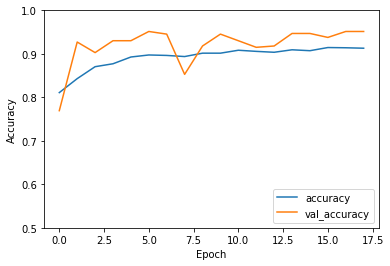

In [16]:
from matplotlib import pyplot as plt
plt.plot(plotter.history['accuracy'],label='accuracy')
plt.plot(plotter.history['val_accuracy'],label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [17]:
import numpy as np
y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(y_pred,axis=1)
print(y_pred.shape)
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes,y_pred))
print('Classification Report')

/home/gurjot/test/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(659,)
Confusion Matrix
[[135  17]
 [ 15 492]]
Classification Report


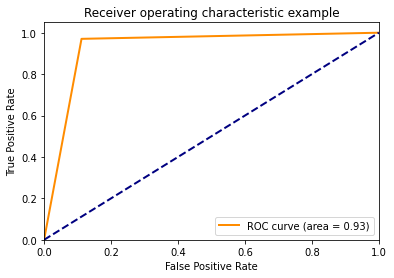

In [18]:
import numpy as np
from sklearn.metrics import roc_curve,auc
from matplotlib import pyplot as plt
fpr, tpr, threshold = roc_curve(test_generator.classes, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()